**Afshin Bayatpour, email: afshin.bayatpour@gmail.com**

##### After scraping the table and formatting it as a DataFrame, add columns with the following information (Percentage of Deaths from Total Cases, Percentage of Recovered Cases from Total Cases, Percentage of Recovered Cases from Total Cases and the Percentage of Population Currently Infected. Plot a bar chart of the 10 countries with the highest percentage of their population currently infected.\

## imports

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import pycountry_convert as pc


## data exploring

In [3]:
website = 'https://www.worldometers.info/coronavirus/?utm_campaign=homeAdvegas1?'
website_url=requests.get(website).text
soup = BeautifulSoup(website_url)

# print(soup.prettify())

In [4]:
my_table = soup.find('tbody')

table_data = []
for row in my_table.findAll('tr'):
    row_data = []
    for cell in row.findAll('td'):
        row_data.append(cell.text)
    if(len(row_data) > 0):
        data_item = {"Country": row_data[1],
                     "Total_Cases": row_data[2],
                     "New_Cases": row_data[3],
                     "Total_Deaths": row_data[4],
                     "New_Deaths": row_data[5],
                     "Total_Recovered": row_data[6],
                     "Active_Cases": row_data[8],
                     "Serious_Critical": row_data[9],
                     "Totcase/1Mpop": row_data[10],
                     "Totdeath/1Mpop": row_data[11],
                     "TotalTests": row_data[12],
                     "Totaltest/1Mpop": row_data[13],
                     "Population": row_data[14],
                    
                    }
        table_data.append(data_item)
#         print(row_data[1])

df = pd.DataFrame(table_data)


In [5]:
# removing first 8 rows:
df.drop(df.index[:8], inplace=True)
df = df.reset_index(drop=True)
df.head()

,Country,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious_Critical,Totcase/1Mpop,Totdeath/1Mpop,TotalTests,Totaltest/1Mpop,Population
0,USA,"33,321,244",,"593,148",,"26,035,314","6,692,782","9,406","100,173","1,783","453,081,055","1,362,085","332,637,917"
1,India,"21,077,410","+6,558","230,168",+17,"17,280,844","3,566,398","8,944","15,148",165,"296,775,209","213,289","1,391,419,959"
2,Brazil,"14,936,464",,"414,645",,"13,529,572","992,247","8,318","69,851","1,939","46,616,516","218,005","213,831,876"
3,France,"5,706,378",,"105,631",,"4,729,174","871,573","5,402","87,260","1,615","77,308,259","1,182,168","65,395,336"
4,Turkey,"4,955,594",,"41,883",,"4,589,501","324,210","3,418","58,231",492,"48,459,224","569,423","85,102,402"


In [9]:
continent = []
missed_contries = []
for country in df.Country:
    try:
    
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
#         print(country_code)
        continent_name = pc.country_alpha2_to_continent_code(country_code)
        continent.append(continent_name)
        
    except:
#         print(country)
        missed_contries.append(country)
        continent.append(np.nan)
df["continent"] = continent

In [52]:
df.describe()

,Country,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious_Critical,Totcase/1Mpop,Totdeath/1Mpop,TotalTests,Totaltest/1Mpop,Population,continent
count,222,222,222,222,222,222,222,222,222,222,222,222,222,203
unique,222,220,16,185,13,220,203,111,221,172,211,211,221,6
top,Mauritania,20,,,,2,0,,,,,,,AF
freq,1,2,207,15,210,2,14,74,2,17,12,12,2,54


In [53]:
df.isna().sum()

Country              0
Total_Cases          0
New_Cases            0
Total_Deaths         0
New_Deaths           0
Total_Recovered      0
Active_Cases         0
Serious_Critical     0
Totcase/1Mpop        0
Totdeath/1Mpop       0
TotalTests           0
Totaltest/1Mpop      0
Population           0
continent           19
dtype: int64

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Country           222 non-null    object
 1   Total_Cases       222 non-null    object
 2   New_Cases         222 non-null    object
 3   Total_Deaths      222 non-null    object
 4   New_Deaths        222 non-null    object
 5   Total_Recovered   222 non-null    object
 6   Active_Cases      222 non-null    object
 7   Serious_Critical  222 non-null    object
 8   Totcase/1Mpop     222 non-null    object
 9   Totdeath/1Mpop    222 non-null    object
 10  TotalTests        222 non-null    object
 11  Totaltest/1Mpop   222 non-null    object
 12  Population        222 non-null    object
 13  continent         203 non-null    object
dtypes: object(14)
memory usage: 24.4+ KB


#### Percentage of Deaths from Total Cases

In [55]:
df["Total_Deaths"] = df["Total_Deaths"].apply(lambda x: x.replace(",", ""))
df["Total_Deaths"] = df["Total_Deaths"].apply(lambda x: x.strip())
df['Total_Deaths'].replace('', np.nan, inplace=True)
df['Total_Deaths'].dropna(inplace = True)
df["Total_Deaths"]=df["Total_Deaths"].astype(float)

In [56]:
df["Total_Cases"]=df["Total_Cases"].apply(lambda x: x.replace(",", ""))
df["Total_Cases"]=df["Total_Cases"].apply(lambda x: x.strip())
df['Total_Cases'].replace('', np.nan, inplace=True)
df['Total_Cases'].dropna()
df["Total_Cases"]=df["Total_Cases"].astype(float)

In [57]:
df["Percentage of Deaths/Total Cases"] = (df["Total_Deaths"])*100/(df["Total_Cases"])
df

,Country,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious_Critical,Totcase/1Mpop,Totdeath/1Mpop,TotalTests,Totaltest/1Mpop,Population,continent,Percentage of Deaths/Total Cases
0,USA,33044068.0,,589207.0,,"25,641,574","6,813,287","9,751","99,349","1,771","445,132,683","1,338,318","332,606,157",NA,1.783095
1,India,18762976.0,"+7,992",208330.0,+17,"15,384,418","3,170,228","8,944","13,487",150,"286,392,086","205,860","1,391,197,718",AS,1.110325
2,Brazil,14592886.0,,401417.0,,"13,152,118","1,039,351","8,318","68,253","1,877","43,818,216","204,943","213,807,144",SA,2.750772
3,France,5592390.0,,104224.0,,"4,498,292","989,874","5,804","85,520","1,594","75,604,728","1,156,160","65,392,975",EU,1.863675
4,Russia,4796557.0,,109731.0,,"4,419,540","267,286","2,300","32,856",752,"128,800,000","882,275","145,986,248",EU,2.287703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,Marshall Islands,4.0,,NaN,,4,0,,67,,,,"59,520",OC,NaN
218,Samoa,3.0,,NaN,,2,1,,15,,,,"199,503",OC,NaN
219,Saint Helena,2.0,,NaN,,2,0,,328,,,,"6,092",NaN,NaN
220,Micronesia,1.0,,NaN,,1,0,,9,,,,"116,017",OC,NaN


#### Percentage of Recovered Cases from Total Cases

In [58]:
df["Total_Recovered"] = df["Total_Recovered"].apply(lambda x: x.replace(",", ""))
df['Total_Recovered'].replace('N/A', np.nan, inplace=True)
df['Total_Recovered'].dropna(inplace = True)
df["Total_Recovered"]=df["Total_Recovered"].astype(float)

In [59]:
df["Percentage of Recovered Cases/Total Cases"] = (df["Total_Recovered"])*100/(df["Total_Cases"])
df

,Country,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious_Critical,Totcase/1Mpop,Totdeath/1Mpop,TotalTests,Totaltest/1Mpop,Population,continent,Percentage of Deaths/Total Cases,Percentage of Recovered Cases/Total Cases
0,USA,33044068.0,,589207.0,,25641574.0,"6,813,287","9,751","99,349","1,771","445,132,683","1,338,318","332,606,157",NA,1.783095,77.598115
1,India,18762976.0,"+7,992",208330.0,+17,15384418.0,"3,170,228","8,944","13,487",150,"286,392,086","205,860","1,391,197,718",AS,1.110325,81.993485
2,Brazil,14592886.0,,401417.0,,13152118.0,"1,039,351","8,318","68,253","1,877","43,818,216","204,943","213,807,144",SA,2.750772,90.126915
3,France,5592390.0,,104224.0,,4498292.0,"989,874","5,804","85,520","1,594","75,604,728","1,156,160","65,392,975",EU,1.863675,80.435950
4,Russia,4796557.0,,109731.0,,4419540.0,"267,286","2,300","32,856",752,"128,800,000","882,275","145,986,248",EU,2.287703,92.139841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,Marshall Islands,4.0,,NaN,,4.0,0,,67,,,,"59,520",OC,NaN,100.000000
218,Samoa,3.0,,NaN,,2.0,1,,15,,,,"199,503",OC,NaN,66.666667
219,Saint Helena,2.0,,NaN,,2.0,0,,328,,,,"6,092",NaN,NaN,100.000000
220,Micronesia,1.0,,NaN,,1.0,0,,9,,,,"116,017",OC,NaN,100.000000


#### Percentage of Population Currently Infected

In [60]:
df["Active_Cases"] = df["Active_Cases"].apply(lambda x: x.replace(",", ""))
df['Active_Cases'].replace('N/A', np.nan, inplace=True)
df['Active_Cases'].dropna(inplace = True)
df["Active_Cases"]=df["Active_Cases"].astype(float)

In [61]:
df["Population"] = df["Population"].apply(lambda x: x.replace(",", ""))
df["Population"] = df["Population"].apply(lambda x: x.strip())

df['Population'].replace("", np.nan, inplace=True)
df['Population'].dropna(inplace = True)
df["Population"]=df["Population"].astype(float)

In [62]:
df["Percentage of Population Currently Infected/Total Cases"] = (df["Active_Cases"])*100/(df["Population"])
df

,Country,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious_Critical,Totcase/1Mpop,Totdeath/1Mpop,TotalTests,Totaltest/1Mpop,Population,continent,Percentage of Deaths/Total Cases,Percentage of Recovered Cases/Total Cases,Percentage of Population Currently Infected/Total Cases
0,USA,33044068.0,,589207.0,,25641574.0,6813287.0,"9,751","99,349","1,771","445,132,683","1,338,318",3.326062e+08,NA,1.783095,77.598115,2.048455
1,India,18762976.0,"+7,992",208330.0,+17,15384418.0,3170228.0,"8,944","13,487",150,"286,392,086","205,860",1.391198e+09,AS,1.110325,81.993485,0.227878
2,Brazil,14592886.0,,401417.0,,13152118.0,1039351.0,"8,318","68,253","1,877","43,818,216","204,943",2.138071e+08,SA,2.750772,90.126915,0.486116
3,France,5592390.0,,104224.0,,4498292.0,989874.0,"5,804","85,520","1,594","75,604,728","1,156,160",6.539298e+07,EU,1.863675,80.435950,1.513731
4,Russia,4796557.0,,109731.0,,4419540.0,267286.0,"2,300","32,856",752,"128,800,000","882,275",1.459862e+08,EU,2.287703,92.139841,0.183090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,Marshall Islands,4.0,,NaN,,4.0,0.0,,67,,,,5.952000e+04,OC,NaN,100.000000,0.000000
218,Samoa,3.0,,NaN,,2.0,1.0,,15,,,,1.995030e+05,OC,NaN,66.666667,0.000501
219,Saint Helena,2.0,,NaN,,2.0,0.0,,328,,,,6.092000e+03,NaN,NaN,100.000000,0.000000
220,Micronesia,1.0,,NaN,,1.0,0.0,,9,,,,1.160170e+05,OC,NaN,100.000000,0.000000


In [63]:
df_sorted = df.sort_values('Percentage of Population Currently Infected/Total Cases',ascending=False)
Highly_infected_countries = df_sorted.head(10)

#### Plot a bar chart of the 10 countries with the highest percentage of their population currently infected

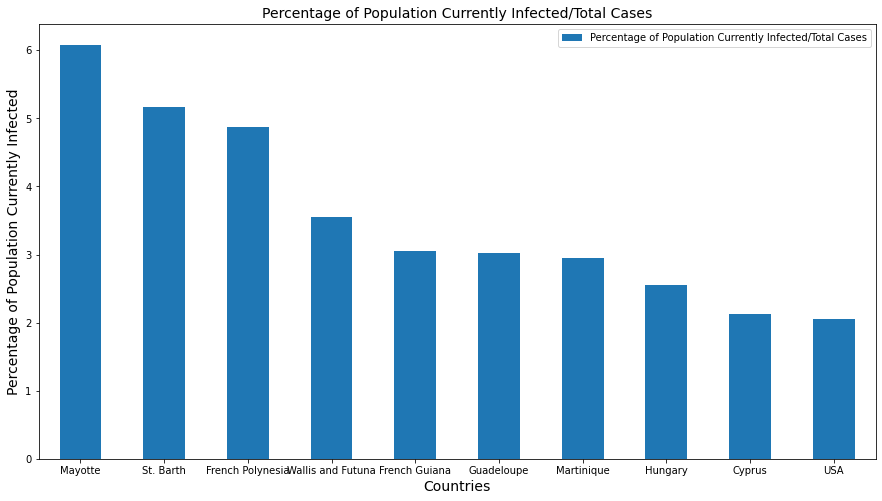

In [64]:
Highly_infected_countries.plot(x='Country', y='Percentage of Population Currently Infected/Total Cases', kind='bar',figsize=(15,8)) 
plt.xticks(rotation=0)
plt.xlabel('Countries',fontdict={'fontsize':14})
plt.ylabel('Percentage of Population Currently Infected',fontdict={'fontsize':14})
plt.title('Percentage of Population Currently Infected/Total Cases',fontdict={'fontsize':14})
plt.show()

## data preprocessing


In [65]:
df.head()

,Country,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious_Critical,Totcase/1Mpop,Totdeath/1Mpop,TotalTests,Totaltest/1Mpop,Population,continent,Percentage of Deaths/Total Cases,Percentage of Recovered Cases/Total Cases,Percentage of Population Currently Infected/Total Cases
0,USA,33044068.0,,589207.0,,25641574.0,6813287.0,"9,751","99,349","1,771","445,132,683","1,338,318",3.326062e+08,NA,1.783095,77.598115,2.048455
1,India,18762976.0,"+7,992",208330.0,+17,15384418.0,3170228.0,"8,944","13,487",150,"286,392,086","205,860",1.391198e+09,AS,1.110325,81.993485,0.227878
2,Brazil,14592886.0,,401417.0,,13152118.0,1039351.0,"8,318","68,253","1,877","43,818,216","204,943",2.138071e+08,SA,2.750772,90.126915,0.486116
3,France,5592390.0,,104224.0,,4498292.0,989874.0,"5,804","85,520","1,594","75,604,728","1,156,160",6.539298e+07,EU,1.863675,80.435950,1.513731
4,Russia,4796557.0,,109731.0,,4419540.0,267286.0,"2,300","32,856",752,"128,800,000","882,275",1.459862e+08,EU,2.287703,92.139841,0.183090


In [66]:
df.dropna(subset = ["continent","Total_Cases", "Total_Deaths", "Total_Recovered"], inplace=True)

In [67]:
df.shape

(191, 17)

In [68]:
df.groupby("continent").count()

,Country,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious_Critical,Totcase/1Mpop,Totdeath/1Mpop,TotalTests,Totaltest/1Mpop,Population,Percentage of Deaths/Total Cases,Percentage of Recovered Cases/Total Cases,Percentage of Population Currently Infected/Total Cases
continent,,,,,,,,,,,,,,,,
AF,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54
AS,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43
EU,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44
NA,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
OC,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
SA,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


In [69]:
le = LabelEncoder()
for label in df[["continent"]]:
    df[label] = le.fit_transform(df[label])  
df.head()

,Country,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious_Critical,Totcase/1Mpop,Totdeath/1Mpop,TotalTests,Totaltest/1Mpop,Population,continent,Percentage of Deaths/Total Cases,Percentage of Recovered Cases/Total Cases,Percentage of Population Currently Infected/Total Cases
0,USA,33044068.0,,589207.0,,25641574.0,6813287.0,"9,751","99,349","1,771","445,132,683","1,338,318",3.326062e+08,3,1.783095,77.598115,2.048455
1,India,18762976.0,"+7,992",208330.0,+17,15384418.0,3170228.0,"8,944","13,487",150,"286,392,086","205,860",1.391198e+09,1,1.110325,81.993485,0.227878
2,Brazil,14592886.0,,401417.0,,13152118.0,1039351.0,"8,318","68,253","1,877","43,818,216","204,943",2.138071e+08,5,2.750772,90.126915,0.486116
3,France,5592390.0,,104224.0,,4498292.0,989874.0,"5,804","85,520","1,594","75,604,728","1,156,160",6.539298e+07,2,1.863675,80.435950,1.513731
4,Russia,4796557.0,,109731.0,,4419540.0,267286.0,"2,300","32,856",752,"128,800,000","882,275",1.459862e+08,2,2.287703,92.139841,0.183090


In [70]:
X = df[["Total_Cases", "Total_Deaths", "Total_Recovered"]]
y = df[["continent"]]


In [71]:
from sklearn.preprocessing import StandardScaler
def preprocessing(X,y):
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #transfering in dataframe format
    scaled_data = pd.DataFrame(X_train_scaled)
    X_train_scaled = scaled_data.rename(columns={0: 'Total_Cases', 1: "Total_Deaths", 2: "Total_Recovered"})

    scaled_data = pd.DataFrame(X_test_scaled)
    X_test_scaled = scaled_data.rename(columns={0: 'Total_Cases', 1: "Total_Deaths", 2: "Total_Recovered"})
    
    return X_train_scaled, X_test_scaled, y_train, y_test


In [72]:
X_train,X_test,y_train,y_test = preprocessing(X,y)

In [73]:
def fit_model(model,X,y):
    model.fit(X,y)
    y_pred = model.predict(X_test)
    print("Accuracy: ",model.score(X_test,y_test))
    print("------------------------------")
    print("Classification Report")
    print("------------------------------")
    print(classification_report(y_test,y_pred))
    print("------------------------------")
    print("Confusion Matrix")
    print("------------------------------")
    print(confusion_matrix(y_test,y_pred))
    print("------------------------------")
    return y_pred

In [74]:
lr = LogisticRegression(max_iter = 1000)
y_test_lr = fit_model(lr,X_train,y_train)

Accuracy:  0.28205128205128205
------------------------------
Classification Report
------------------------------
              precision    recall  f1-score   support

           0       0.31      0.90      0.46        10
           1       0.00      0.00      0.00         5
           2       0.50      0.13      0.21        15
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2

    accuracy                           0.28        39
   macro avg       0.14      0.17      0.11        39
weighted avg       0.27      0.28      0.20        39

------------------------------
Confusion Matrix
------------------------------
[[9 0 1 0 0 0]
 [4 0 1 0 0 0]
 [7 5 2 1 0 0]
 [6 0 0 0 0 0]
 [1 0 0 0 0 0]
 [2 0 0 0 0 0]]
------------------------------


C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

In [75]:
dtree = DecisionTreeClassifier()

y_test_dtree = fit_model(dtree,X_train,y_train)

Accuracy:  0.38461538461538464
------------------------------
Classification Report
------------------------------
              precision    recall  f1-score   support

           0       0.44      0.70      0.54        10
           1       0.25      0.60      0.35         5
           2       0.67      0.27      0.38        15
           3       0.33      0.17      0.22         6
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2

    accuracy                           0.38        39
   macro avg       0.28      0.29      0.25        39
weighted avg       0.45      0.38      0.36        39

------------------------------
Confusion Matrix
------------------------------
[[7 1 2 0 0 0]
 [1 3 0 0 0 1]
 [3 5 4 2 0 1]
 [4 1 0 1 0 0]
 [1 0 0 0 0 0]
 [0 2 0 0 0 0]]
------------------------------


C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
knn = KNeighborsClassifier(n_neighbors=5) 

fit_model(knn,X_train,y_train)

C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWa

Accuracy:  0.3333333333333333
------------------------------
Classification Report
------------------------------
              precision    recall  f1-score   support

           0       0.37      0.70      0.48        10
           1       0.18      0.40      0.25         5
           2       0.50      0.13      0.21        15
           3       0.40      0.33      0.36         6
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2

    accuracy                           0.33        39
   macro avg       0.24      0.26      0.22        39
weighted avg       0.37      0.33      0.29        39

------------------------------
Confusion Matrix
------------------------------
[[7 2 0 1 0 0]
 [1 2 1 1 0 0]
 [6 6 2 1 0 0]
 [3 0 1 2 0 0]
 [1 0 0 0 0 0]
 [1 1 0 0 0 0]]
------------------------------


array([1, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 1, 0, 2, 0, 3,
       0, 1, 1, 2, 1, 3, 0, 1, 3, 0, 1, 0, 0, 3, 0, 1, 1])

In [77]:
s = pd.value_counts(y.continent)
s1 = pd.Series({'nunique': len(s), 'unique values': s.index.tolist()})
s.append(s1)

0                                54
2                                44
1                                43
3                                30
5                                13
4                                 7
nunique                           6
unique values    [0, 2, 1, 3, 5, 4]
dtype: object

## applying over sampling


In [78]:
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X, y)

In [79]:
s = pd.value_counts(y_over.continent)
s1 = pd.Series({'nunique': len(s), 'unique values': s.index.tolist()})
s.append(s1)

5                                54
4                                54
3                                54
2                                54
1                                54
0                                54
nunique                           6
unique values    [5, 4, 3, 2, 1, 0]
dtype: object

In [80]:
X_train,X_test,y_train,y_test = preprocessing(X_over, y_over)

In [81]:
lr = LogisticRegression(max_iter = 1000)
fit_model(lr,X_train,y_train)

Accuracy:  0.16923076923076924
------------------------------
Classification Report
------------------------------
              precision    recall  f1-score   support

           0       0.11      0.83      0.20         6
           1       0.25      0.08      0.12        12
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        13
           5       0.42      0.62      0.50         8

    accuracy                           0.17        65
   macro avg       0.13      0.26      0.14        65
weighted avg       0.11      0.17      0.10        65

------------------------------
Confusion Matrix
------------------------------
[[ 5  0  0  0  0  1]
 [ 9  1  0  1  0  1]
 [ 7  3  0  3  0  4]
 [ 8  0  0  0  0  1]
 [13  0  0  0  0  0]
 [ 3  0  0  0  0  5]]
------------------------------


C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

array([0, 0, 5, 0, 5, 0, 0, 0, 5, 0, 5, 0, 0, 0, 5, 0, 0, 1, 0, 0, 5, 0,
       0, 0, 0, 1, 5, 3, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0,
       1, 3, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 3, 0, 0, 5])

(array([249.,   6.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.25450907,  1.01113103,  2.27677113,  3.54241124,  4.80805134,
         6.07369144,  7.33933154,  8.60497165,  9.87061175, 11.13625185,
        12.40189195]),
 <a list of 10 Patch objects>)

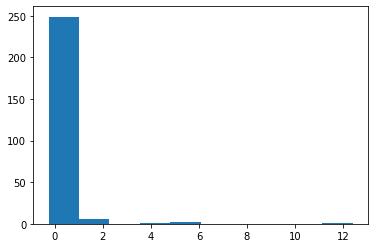

In [82]:
plt.hist(X_train["Total_Cases"])

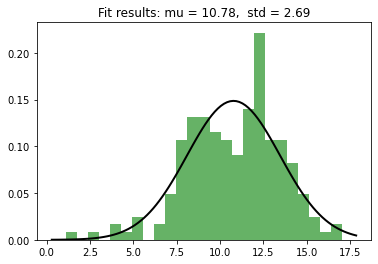

In [83]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Generate some data for this demonstration.
data = np.log(X["Total_Recovered"])
#data = X1["Total_Deaths"]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [84]:
X = np.log(X)

In [85]:
X_over, y_over = oversample.fit_resample(X, y)

In [86]:
X_train,X_test,y_train,y_test = preprocessing(X_over, y_over)

In [87]:
lr = LogisticRegression(max_iter = 1000)
fit_model(lr,X_train,y_train)

Accuracy:  0.2
------------------------------
Classification Report
------------------------------
              precision    recall  f1-score   support

           0       0.08      0.17      0.11         6
           1       0.20      0.17      0.18        12
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         9
           4       0.54      0.54      0.54        13
           5       0.12      0.38      0.19         8

    accuracy                           0.20        65
   macro avg       0.16      0.21      0.17        65
weighted avg       0.17      0.20      0.17        65

------------------------------
Confusion Matrix
------------------------------
[[ 1  2  0  1  1  1]
 [ 4  2  0  1  2  3]
 [ 1  2  0  0  1 13]
 [ 2  1  0  0  2  4]
 [ 3  0  0  3  7  0]
 [ 2  3  0  0  0  3]]
------------------------------


C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

array([4, 3, 5, 3, 5, 0, 5, 3, 5, 3, 0, 4, 0, 1, 5, 5, 0, 1, 0, 3, 5, 1,
       4, 5, 4, 5, 5, 5, 4, 5, 0, 5, 5, 5, 4, 0, 0, 4, 4, 5, 1, 1, 4, 0,
       5, 5, 4, 5, 4, 0, 0, 1, 1, 5, 5, 5, 4, 4, 0, 5, 1, 5, 1, 0, 1])

In [88]:
dtree = DecisionTreeClassifier(max_depth=10)

y_test_dtree = fit_model(dtree,X_train,y_train)

Accuracy:  0.3384615384615385
------------------------------
Classification Report
------------------------------
              precision    recall  f1-score   support

           0       0.22      0.33      0.27         6
           1       0.17      0.08      0.11        12
           2       0.38      0.18      0.24        17
           3       0.19      0.33      0.24         9
           4       0.67      0.62      0.64        13
           5       0.36      0.62      0.45         8

    accuracy                           0.34        65
   macro avg       0.33      0.36      0.33        65
weighted avg       0.35      0.34      0.33        65

------------------------------
Confusion Matrix
------------------------------
[[2 1 0 3 0 0]
 [3 1 1 3 2 2]
 [2 3 3 3 1 5]
 [1 0 2 3 1 2]
 [1 1 0 3 8 0]
 [0 0 2 1 0 5]]
------------------------------


In [89]:
knn = KNeighborsClassifier(n_neighbors=1) 

fit_model(knn,X_train,y_train)

Accuracy:  0.4153846153846154
------------------------------
Classification Report
------------------------------
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         6
           1       0.50      0.33      0.40        12
           2       0.25      0.12      0.16        17
           3       0.27      0.33      0.30         9
           4       0.91      0.77      0.83        13
           5       0.32      0.75      0.44         8

    accuracy                           0.42        65
   macro avg       0.42      0.44      0.40        65
weighted avg       0.44      0.42      0.40        65

------------------------------
Confusion Matrix
------------------------------
[[ 2  0  1  2  0  1]
 [ 2  4  1  2  1  2]
 [ 1  3  2  3  0  8]
 [ 1  0  3  3  0  2]
 [ 2  1  0  0 10  0]
 [ 0  0  1  1  0  6]]
------------------------------


C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([3, 0, 3, 4, 5, 3, 1, 4, 2, 4, 5, 4, 3, 5, 5, 5, 5, 1, 3, 4, 5, 1,
       1, 3, 4, 5, 5, 5, 4, 2, 0, 2, 5, 5, 0, 1, 3, 4, 4, 2, 1, 1, 3, 5,
       5, 1, 3, 5, 3, 0, 0, 0, 2, 5, 2, 3, 4, 4, 0, 5, 2, 5, 0, 2, 5])

### Grid search

In [90]:
model = LogisticRegression(max_iter = 1000)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)
# execute search
result_lr_grid = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result_lr_grid.best_score_)
print('Best Hyperparameters: %s' % result_lr_grid.best_params_)

Best Score: 0.4518399714871246
Best Hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.45179542 0.45179542        nan        nan        nan 0.18533369
 0.18533369 0.18533369 0.30499866        nan        nan        nan
 0.45179542 0.45179542        nan        nan        nan 0.18533369
 0.18533369 0.18533369 0.30499866        nan        nan        nan
 0.45179542 0.45179542        nan        nan        nan 0.18533369
 0.30883008 0.30883008 0.30887463        nan        nan        nan
 0.45179542 0.45179542        nan        nan        nan 0.18533369
 0.37066738 0.37066738 0.30504321        nan        nan        nan
 0.45179542 0.45179542        nan        nan        nan 0.34001604
 0.3940123  0.3940123  0.35529716        nan        nan        nan
 0.45179542 0.45179542        nan        nan        nan 0.39383409
 0.40929342 0.40929342 0.39378954        nan        nan        nan
 0.45179542 0.45179542        nan        nan        

In [91]:
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
# define search space
space = dict()
space['n_neighbors'] = [1, 3, 5, 7, 9, 11,13,15,30,45]
space['leaf_size'] = list(range(1,20))
space['p'] = [1,2]
# define search
knn = KNeighborsClassifier()
search = GridSearchCV(knn, space, scoring='accuracy', n_jobs=-1, cv=cv)
# execute search
result_knn_grid = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result_knn_grid.best_score_)
print('Best Hyperparameters: %s' % result_knn_grid.best_params_)

Best Score: 0.4595473581038938
Best Hyperparameters: {'leaf_size': 1, 'n_neighbors': 1, 'p': 2}


C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [92]:
knn = KNeighborsClassifier(n_neighbors=1, leaf_size = 1, p = 2) 

fit_model(knn,X_train,y_train)

Accuracy:  0.4153846153846154
------------------------------
Classification Report
------------------------------
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         6
           1       0.50      0.33      0.40        12
           2       0.25      0.12      0.16        17
           3       0.27      0.33      0.30         9
           4       0.91      0.77      0.83        13
           5       0.32      0.75      0.44         8

    accuracy                           0.42        65
   macro avg       0.42      0.44      0.40        65
weighted avg       0.44      0.42      0.40        65

------------------------------
Confusion Matrix
------------------------------
[[ 2  0  1  2  0  1]
 [ 2  4  1  2  1  2]
 [ 1  3  2  3  0  8]
 [ 1  0  3  3  0  2]
 [ 2  1  0  0 10  0]
 [ 0  0  1  1  0  6]]
------------------------------


C:\Users\AfshIn\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([3, 0, 3, 4, 5, 3, 1, 4, 2, 4, 5, 4, 3, 5, 5, 5, 5, 1, 3, 4, 5, 1,
       1, 3, 4, 5, 5, 5, 4, 2, 0, 2, 5, 5, 0, 1, 3, 4, 4, 2, 1, 1, 3, 5,
       5, 1, 3, 5, 3, 0, 0, 0, 2, 5, 2, 3, 4, 4, 0, 5, 2, 5, 0, 2, 5])